In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data

--2025-02-25 06:46:11--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip.1’

PennFudanPed.zip.1    0%[                    ] 265.54K  12.6KB/s    eta 53m 52s^C


In [ ]:
!cd data && unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# ======================
# PennFudanPed Dataset
# ======================
class PennFudanDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        root: PennFudanPed 폴더의 상위 경로 (예: "./data/PennFudanPed")
        transform: 이미지 및 마스크에 적용할 transform (동일하게 적용)
        """
        self.root = root
        self.imgs_dir = os.path.join(root, "PNGImages")
        self.masks_dir = os.path.join(root, "PedMasks")
        self.imgs = list(sorted(os.listdir(self.imgs_dir)))
        self.masks = list(sorted(os.listdir(self.masks_dir)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # 이미지 로드
        img_path = os.path.join(self.imgs_dir, self.imgs[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # mask는 각 인스턴스마다 다른 값이지만, 이진 분할을 위해
        # 0은 배경, 그 외는 보행자(1)로 처리
        mask = np.array(mask)
        # 여러 인스턴스 픽셀값 > 0을 1로 변경
        mask = np.where(mask > 0, 1, 0).astype('uint8')
        mask = Image.fromarray(mask)

        # transform 적용 (동일하게 이미지와 마스크에 적용)
        if self.transform is not None:
            # mask의 경우 PIL.Image.NEAREST를 사용해야 함
            img, mask = self.transform(img, mask)

        return img, mask

# 예시: transform 함수 (resize, tensor 변환)
def joint_transform(img, mask, size=(256, 256)):
    # Resize: 이미지와 mask에 동일하게 적용
    img = TF.resize(img, size)
    mask = TF.resize(mask, size, interpolation=Image.NEAREST)
    # ToTensor: 이미지는 [0,1] 실수 tensor, mask는 int tensor
    img = TF.to_tensor(img)
    mask = torch.as_tensor(np.array(mask), dtype=torch.long)
    return img, mask

# ======================
# UNet 모델 정의
# ======================
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(512, 512)
        )
        self.up1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 256)
        self.up2 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 128)
        self.up3 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 64)
        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)     # [B,64,H,W]
        x2 = self.down1(x1)  # [B,128,H/2,W/2]
        x3 = self.down2(x2)  # [B,256,H/4,W/4]
        x4 = self.down3(x3)  # [B,512,H/8,W/8]
        x5 = self.down4(x4)  # [B,512,H/16,W/16]

        x = self.up1(x5)     # upsample to H/8
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)

        x = self.up2(x)      # H/4
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)

        x = self.up3(x)      # H/2
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)

        x = self.up4(x)      # H
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)

        logits = self.outc(x)
        return logits

# ======================
# 학습 및 평가 루프
# ======================
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        # masks: [B, H, W] -> loss 함수(CrossEntropyLoss)는 class index를 기대하므로 shape 그대로 사용
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  # outputs: [B, n_classes, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss



Epoch 1/25, Train Loss: 0.6314, Val Loss: 0.5107
Epoch 2/25, Train Loss: 0.4259, Val Loss: 0.3671
Epoch 3/25, Train Loss: 0.3483, Val Loss: 0.3527
Epoch 4/25, Train Loss: 0.3204, Val Loss: 0.2956
Epoch 5/25, Train Loss: 0.2773, Val Loss: 0.2664
Epoch 6/25, Train Loss: 0.2542, Val Loss: 0.2722
Epoch 7/25, Train Loss: 0.2322, Val Loss: 0.2294
Epoch 8/25, Train Loss: 0.2038, Val Loss: 0.2510
Epoch 9/25, Train Loss: 0.1933, Val Loss: 0.2052
Epoch 10/25, Train Loss: 0.1791, Val Loss: 0.2149
Epoch 11/25, Train Loss: 0.1685, Val Loss: 0.1989
Epoch 12/25, Train Loss: 0.1487, Val Loss: 0.2192
Epoch 13/25, Train Loss: 0.1377, Val Loss: 0.1841
Epoch 14/25, Train Loss: 0.1280, Val Loss: 0.2233
Epoch 15/25, Train Loss: 0.1212, Val Loss: 0.1763
Epoch 16/25, Train Loss: 0.1132, Val Loss: 0.1878
Epoch 17/25, Train Loss: 0.1068, Val Loss: 0.1662
Epoch 18/25, Train Loss: 0.0983, Val Loss: 0.1864
Epoch 19/25, Train Loss: 0.0889, Val Loss: 0.1603
Epoch 20/25, Train Loss: 0.0817, Val Loss: 0.1827
Epoch 21/

In [ ]:

# ======================
# 메인 실행 코드
# ======================

# 하이퍼파라미터 설정
num_epochs = 25
batch_size = 4
learning_rate = 1e-4

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset 및 DataLoader
dataset = PennFudanDataset(root="./data/PennFudanPed", transform=joint_transform)

# 학습/검증 분할 (예: 80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 모델, 손실함수, optimizer
model = UNet(n_channels=3, n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()  # output: [B, 2, H, W], mask: [B, H, W] (각 픽셀 0 또는 1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    # 가장 낮은 검증 손실 모델 저장 (옵션)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet.pth")

Epoch 1/25, Train Loss: 0.6466, Val Loss: 0.5167
Epoch 2/25, Train Loss: 0.4394, Val Loss: 0.3986
Epoch 3/25, Train Loss: 0.3694, Val Loss: 0.3308
Epoch 4/25, Train Loss: 0.3087, Val Loss: 0.3029
Epoch 5/25, Train Loss: 0.2698, Val Loss: 0.3065
Epoch 6/25, Train Loss: 0.2464, Val Loss: 0.2718
Epoch 7/25, Train Loss: 0.2290, Val Loss: 0.2445
Epoch 8/25, Train Loss: 0.1995, Val Loss: 0.2331
Epoch 9/25, Train Loss: 0.1944, Val Loss: 0.2578
Epoch 10/25, Train Loss: 0.1817, Val Loss: 0.2025
Epoch 11/25, Train Loss: 0.1683, Val Loss: 0.2248
Epoch 12/25, Train Loss: 0.1587, Val Loss: 0.2289
Epoch 13/25, Train Loss: 0.1458, Val Loss: 0.2101
Epoch 14/25, Train Loss: 0.1384, Val Loss: 0.2165
Epoch 15/25, Train Loss: 0.1412, Val Loss: 0.1985
Epoch 16/25, Train Loss: 0.1268, Val Loss: 0.2311
Epoch 17/25, Train Loss: 0.1171, Val Loss: 0.1828
Epoch 18/25, Train Loss: 0.1149, Val Loss: 0.2778
Epoch 19/25, Train Loss: 0.1062, Val Loss: 0.1881
Epoch 20/25, Train Loss: 0.0940, Val Loss: 0.1778
Epoch 21/

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_images=4):
    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)  # 출력: [B, n_classes, H, W]
            # 예측: 각 픽셀에서 채널의 argmax (배경:0, 보행자:1)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            imgs = imgs.cpu().numpy().transpose(0, 2, 3, 1)  # [B, H, W, C]로 변경
            masks = masks.cpu().numpy()

            for i in range(min(num_images, imgs.shape[0])):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(imgs[i])
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(masks[i], cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(preds[i], cmap="gray")
                axs[2].set_title("Predicted Mask")
                axs[2].axis("off")
                plt.show()
            break

val_dataloader_shuffle = DataLoader(val_dataset, batch_size=4, shuffle=True)

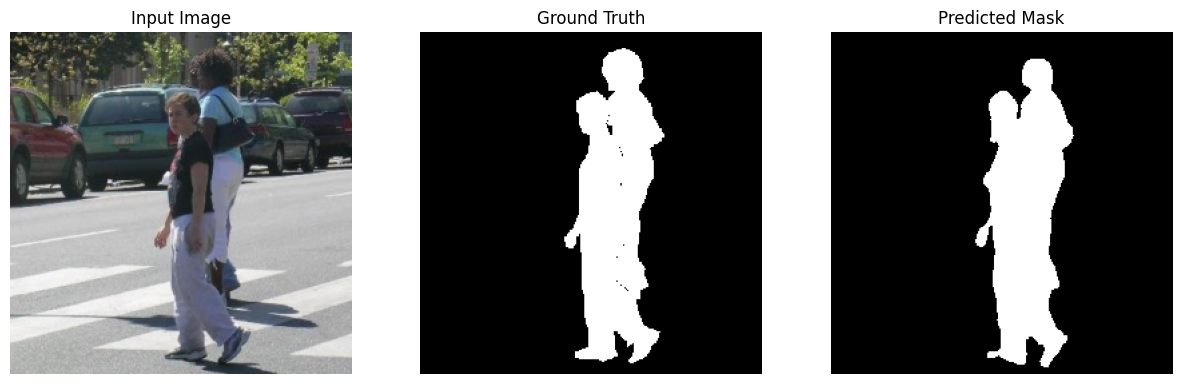

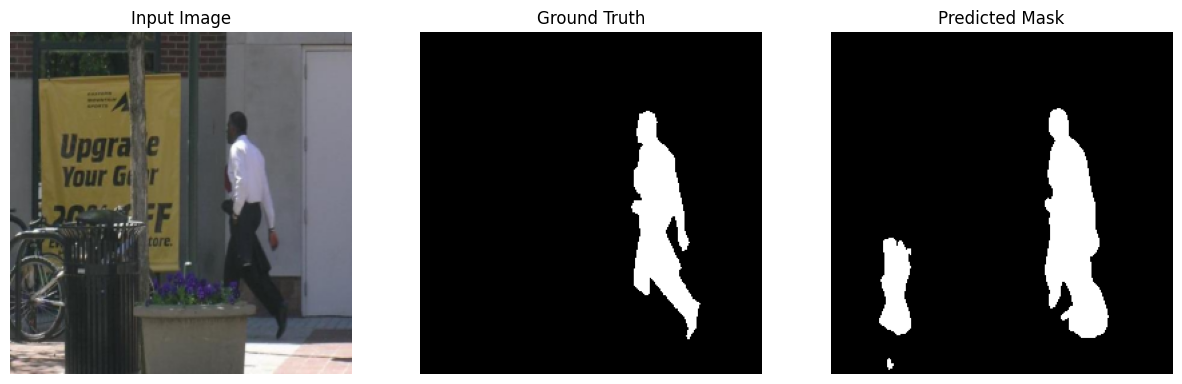

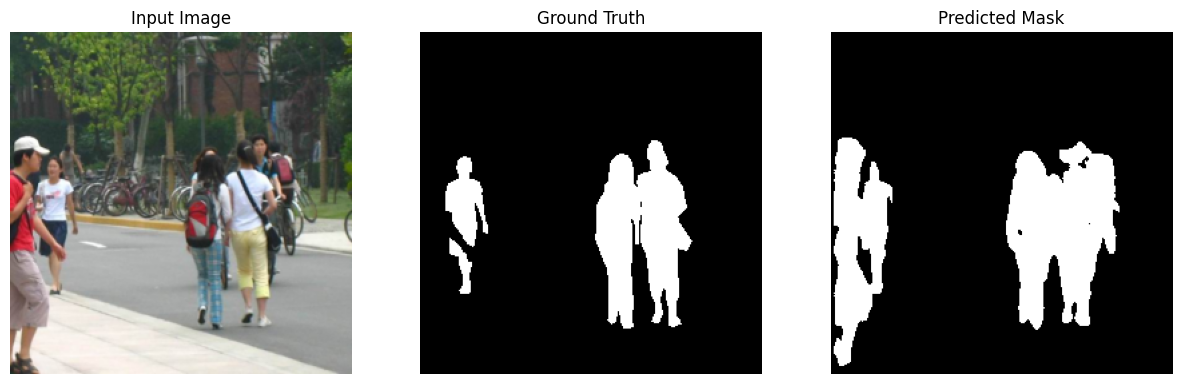

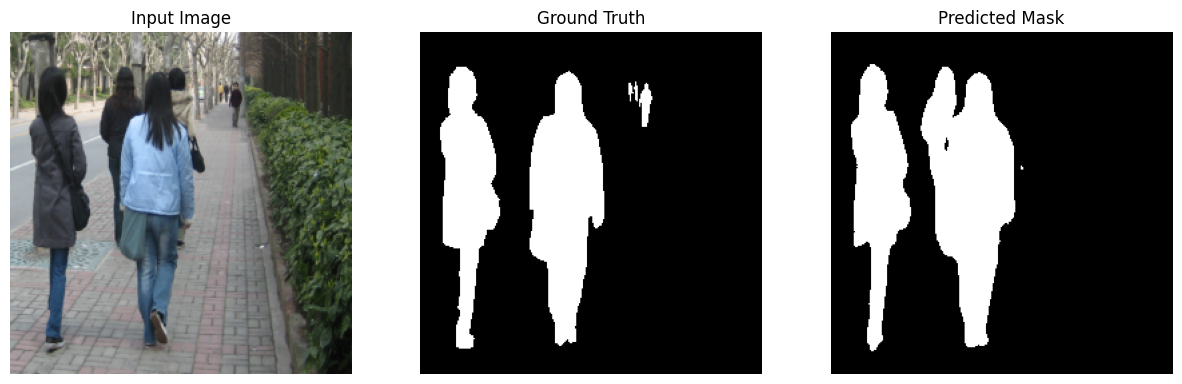

In [ ]:
visualize_predictions(model, val_loader, device)
